In [63]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import datetime as dt
from scipy import interpolate as itp
from sklearn import utils

In [64]:
def e_cdf(dset, val):
    l = len(dset)
    return sum([1 for m in dset if m<=val])/l
def gen_edf(dset, inc = -1):
    max_v = max(dset)
    min_v = min(dset)
    if(inc<0):
        inc = (max_v - min_v)/(len(dset)-1)
    smooth = (max_v-min_v)//inc+1
    vals = np.linspace(min_v,max_v,num=smooth)
    return (vals,np.array([e_cdf(dset,val) for val in vals]))
def gen_epdf(x,y,smoothness = 1):
    new_x = [(x[i+smoothness]+x[i])/2 for i in np.arange(0,len(x)-smoothness,smoothness) ]
    new_y = [(y[i+smoothness]-y[i])/(x[i+smoothness]-x[i]) for i in np.arange(0,len(y)-smoothness,smoothness)]
    return (new_x,new_y)
    

In [65]:
def get_samp(buil,y):
    with h5py.File('cleaned.hdf5','r') as f: 
        d =pd.DataFrame(f['utexas/{}/{}'.format(buil,y)][()])
        return byte_to_obj(d)

In [66]:
def byte_to_obj(build_df):
    df = build_df.copy()
    #Byte to String (decode utf8) to Datetime (parsetime with format YYYY-mm-dd HH:MM:SS)
    df.loc[:,0] = df.apply(lambda x:dt.datetime.strptime(x[0].decode('utf8'),'%Y-%m-%d %H:%M:%S'),axis=1 )
    #Byte to String (decode utf8) to float
    df.loc[:,1] = df.apply(lambda x: float(x[1].decode('utf8')),axis=1)
    return df
#Clean zero values
def clean_zero(build_df):
    df = build_df.copy()
    #Return times and data where usage is positive.
    #Filters zero and negative numbers
    return df[df[1]>0]

def daily_profile(building, year):
    with h5py.File(file_loc,'r') as f:
        df = pd.DataFrame(f['{}/{}/{}'.format(dset,building,year)][()])
        df = clean_zero(byte_to_obj(df))
        data = []
        for h in range(24):
            hour_data = df[df.apply(lambda x: x[0].hour==h,axis=1)].loc[:,1]
            data.append(hour_data.tolist())
    return data


<h2><font color = #bf5700> Distribution of Data</font> </h2> 
We wonder what the distribution of usage data is for a cleaned dataset. utexas/ADH/2016 is used as an example here

In [67]:
df = get_samp('ADH',2016)
vals = df[1]

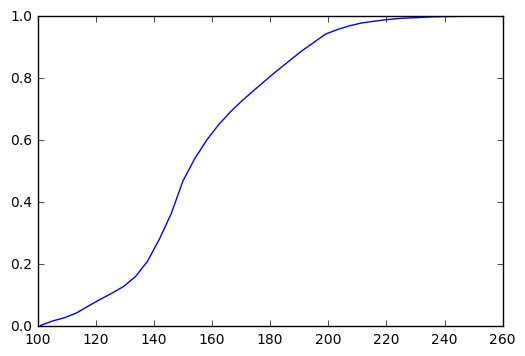

In [68]:
x,y = gen_edf(vals,inc = 4)
plt.plot(x,y,'-')
plt.show()

In [41]:
tck = itp.splrep(x, y)

In [42]:
xnew = np.linspace(min(x),max(x),num=1000)
ynew = itp.splev(xnew, tck, der=1)

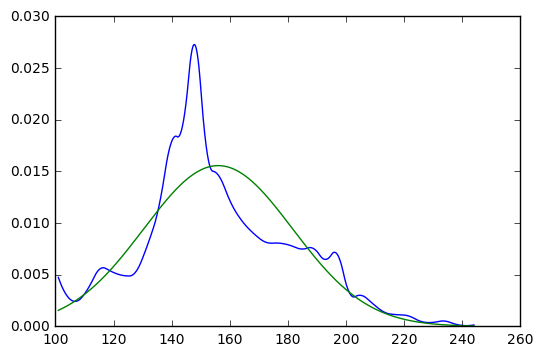

In [70]:
plt.plot(xnew,ynew,'-')
plt.plot(xnew,r.pdf(xnew),'-')
plt.show()

In [56]:
np.std(vals)

25.63026949807411

In [44]:
def c_moment(sample, m):
    mu = np.mean(sample)
    moms = [(r-mu)**m for r in sample]
    return np.mean(moms)
    

In [45]:
lel = vals.tolist()

In [53]:
c_moment(lel,4)/(c_moment(lel,2))**2

2.9186116670554512

In [57]:
from scipy import stats as stt

In [1]:
r = stt.norm(loc = 156, scale = 25.6302)

NameError: name 'stt' is not defined

<h2><font color = #bf5700>Confidence Bands Exploratory Analysis </font></h2>
To determine if daily profiles are <em>stable</em>, we graph multiple profiles from the same building in different years

In [11]:
file_loc = 'cleaned.hdf5'
dset = 'utexas'
pf_15 = daily_profile('ADH',2015)
pf_16 = daily_profile('ADH',2016)

In [61]:
pf_15

[[128.50000000000003,
  128.50000000000003,
  128.50000000000003,
  127.24999999999994,
  129.24999999999997,
  127.74999999999997,
  127.24999999999994,
  131.99999999999997,
  130.24999999999997,
  136.5,
  136.24999999999997,
  130.50000000000003,
  147.99999999999994,
  181.00000000000006,
  201.50000000000009,
  199.74999999999994,
  199.25,
  195.75000000000009,
  211.25,
  221.99999999999997,
  209.49999999999991,
  205.25000000000006,
  209.99999999999994,
  217.99999999999997,
  191.24999999999994,
  206.74999999999994,
  219.24999999999994,
  230.75000000000006,
  208.25000000000006,
  220.99999999999991,
  213.50000000000003,
  213.99999999999994,
  226.00000000000009,
  212.25000000000006,
  214.49999999999997,
  224.24999999999991,
  224.24999999999991,
  188.24999999999994,
  198.0,
  233.50000000000003,
  198.75,
  213.25,
  214.49999999999997,
  201.0,
  229.5,
  206.99999999999994,
  206.00000000000003,
  211.00000000000003,
  207.99999999999997,
  202.99999999999997,


In [36]:
ax = sns.tsplot(data=pf_15, ax = 1)

C:\Users\raghu\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [37]:
def z_normalize(avs,nested_data=False):
    #If data is direct output from profile, it is in form [[a1,a2,a3,a4,...],[b1,b2,b3,b4,...],...]
    if(nested_data):
        arr = [np.array(h_data) for h_data in avs]
        mus = [np.mean(h_data) for h_data in avs]
        mu = np.mean(mus)
        std = np.std(mus)
        return np.array([(r - mu)/std for r in arr])
    else:
        mu = np.mean(avs)
        std = np.std(avs)
        return (np.array(avs)-mu)/std

In [59]:
def bootstrap(data,confidence=95,n_iter=1000):
    bstrap = [[np.mean(utils.resample(azn)) for azn in data] for _ in range(n_iter)]
    print(bstrap)
    d = [[occ[i]for occ in bstrap] for i in range(24)]
    ub = [np.percentile(hour,confidence) for hour in d]
    lb = [np.percentile(hour,100-confidence) for hour in d]
    return (lb,ub)
        